In [ ]:
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.1/678.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/3

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

# Lets create a synthetic data-set
x, y = make_classification(n_samples=100, class_sep=2, n_features=30, random_state=42)

# Split the data-set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Now we train in the clear and quantize the weights
model = LogisticRegression(n_bits=8)
model.fit(X_train, y_train)

# We can simulate the predictions in the clear
y_pred_clear = model.predict(X_test)

# We then compile on a representative set
model.compile(X_train)

# Finally we run the inference on encrypted inputs !
y_pred_fhe = model.predict(X_test, fhe="execute")

print("In clear  :", y_pred_clear)
print("In FHE    :", y_pred_fhe)
print(f"Similarity: {int((y_pred_fhe == y_pred_clear).mean()*100)}%")


In clear  : [0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0]
In FHE    : [0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0]
Similarity: 100%


In [ ]:
# Predict probability for a single example
y_proba_fhe = model.predict_proba(X_test[[0]], fhe="execute")

# Quantize an original float input
q_input = model.quantize_input(X_test[[0]])

# Encrypt the input
q_input_enc = model.fhe_circuit.encrypt(q_input)

# Execute the linear product in FHE
q_y_enc = model.fhe_circuit.run(q_input_enc)

# Decrypt the result (integer)
q_y = model.fhe_circuit.decrypt(q_y_enc)

# De-quantize and post-process the result
y0 = model.post_processing(model.dequantize_output(q_y))

print("Probability with `predict_proba`: ", y_proba_fhe)
print("Probability with encrypt/run/decrypt calls: ", y0)

Probability with `predict_proba`:  [[0.99621148 0.00378852]]
Probability with encrypt/run/decrypt calls:  [[0.99621148 0.00378852]]


In [ ]:
import shutil
from pathlib import Path
from time import time
from typing import Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

In [ ]:
!pip install tenseal
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Load your dataset from CSV
df = pd.read_csv('/content/simulated_data.csv')

# Display the first few rows of the dataframe
print("Original DataFrame:")
print(df.head())

# Step 2: Preprocess the datetime column
# Convert TX_DATETIME to datetime type
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Extract useful datetime features
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAY'] = df['TX_DATETIME'].dt.day
df['TX_MONTH'] = df['TX_DATETIME'].dt.month
df['TX_YEAR'] = df['TX_DATETIME'].dt.year
df['TX_DAYOFWEEK'] = df['TX_DATETIME'].dt.dayofweek

# For cyclical features, apply sine and cosine transformation
df['TX_HOUR_sin'] = np.sin(2 * np.pi * df['TX_HOUR'] / 24)
df['TX_HOUR_cos'] = np.cos(2 * np.pi * df['TX_HOUR'] / 24)
df['TX_DAY_sin'] = np.sin(2 * np.pi * df['TX_DAY'] / 31)
df['TX_DAY_cos'] = np.cos(2 * np.pi * df['TX_DAY'] / 31)
df['TX_MONTH_sin'] = np.sin(2 * np.pi * df['TX_MONTH'] / 12)
df['TX_MONTH_cos'] = np.cos(2 * np.pi * df['TX_MONTH'] / 12)

# Drop the original TX_DATETIME column and the raw cyclic columns
df = df.drop(columns=['TX_DATETIME', 'TX_HOUR', 'TX_DAY', 'TX_MONTH'])

# Encode categorical columns (if any)
categorical_columns = ['CUSTOMER_ID', 'TERMINAL_ID']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select all columns for PCA (now all should be numerical)
# features = df.columns
# x = df[features]

# Step 3: Separate features and target variable
features = df.drop(columns=['TX_FRAUD'])
target = df['TX_FRAUD']

# Step 3: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Step 4: Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca.fit(scaled_data)

# Step 5: Transform the dataset
pca_data = pca.transform(scaled_data)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])

# Optionally, you can concatenate the PCA components with the target variable
result_df = pd.concat([df, pca_df, target.reset_index(drop=True)], axis=1)

# Optionally, you can concatenate the PCA components with the original dataframe
# result_df = pd.concat([df, pca_df], axis=1)

# Display the resulting DataFrame with PCA components
print("\nDataFrame with PCA components:")
print(result_df.head())

# Save the result to a new CSV file
result_df.to_csv('transactions_with_pca_all_columns.csv', index=False)

# Print the explained variance ratio
print("\nExplained variance ratio by each component:")
print(pca.explained_variance_ratio_)


Original DataFrame:
   TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0               0  2018-04-01 00:07:56            2          316     146.00   
1               1  2018-04-01 00:30:05          360          584      92.74   
2               2  2018-04-01 00:32:35          183          992      39.30   
3               3  2018-04-01 00:43:59          382          283      15.35   
4               4  2018-04-01 00:45:51          381          799      23.15   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  
0              476             0         0  
1             1805             0         0  
2             1955             0         0  
3             2639             0         0  
4             2751             0         0  

DataFrame with PCA components:
   TRANSACTION_ID  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  \
0               0            2          300     146.00              476   
1               1          359          553      92.7

In [ ]:
data = result_df.set_axis([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], axis='columns')
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,2,300,146.00,476,0,0,2018,6,0.0,1.0,0.201299,0.97953,0.866025,-0.5,-2.710537,1.983723,0
1,1,359,553,92.74,1805,0,0,2018,6,0.0,1.0,0.201299,0.97953,0.866025,-0.5,-2.718730,1.630334,0
2,2,183,943,39.30,1955,0,0,2018,6,0.0,1.0,0.201299,0.97953,0.866025,-0.5,-2.732855,2.121717,0
3,3,381,267,15.35,2639,0,0,2018,6,0.0,1.0,0.201299,0.97953,0.866025,-0.5,-2.736997,1.163457,0
4,4,380,760,23.15,2751,0,0,2018,6,0.0,1.0,0.201299,0.97953,0.866025,-0.5,-2.734394,1.649135,0


In [ ]:
# for credit card data - IMPORTANT
# data = pd.read_csv("/creditcard.csv")
# data = data.dropna()
# data = data.set_axis([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31], axis='columns')
# data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

# for simulated data
x = data.drop(18, axis=1)
y = data[18]

print(y)


# for credit card
# x = data.drop(31, axis=1)
# y = data[31]

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3,stratify=y, random_state=42)

0        0
1        0
2        0
3        0
4        0
        ..
28421    1
28422    0
28423    0
28424    0
28425    0
Name: 18, Length: 28426, dtype: int64


In [ ]:
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

18
0    26917
1     1509
Name: count, dtype: int64
18
0    18842
1     1056
Name: count, dtype: int64
18
0    8075
1     453
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, accuracy_score, average_precision_score


def print_Table(y_test, y_pred):

    # Assuming y_test and y_pred are your true labels and predicted labels respectively

    # Calculate metrics for both classes
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    f2 = fbeta_score(y_test, y_pred, beta=2, average=None)
    avg_precision = average_precision_score(y_test, y_pred, average=None)
    accuracy = accuracy_score(y_test, y_pred)

    # Create a DataFrame to display the results
    metrics = pd.DataFrame({
        'Class': ['Legit', 'Fraud'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F2 Score': f2,
        'Average Precision': avg_precision
    })

    # Display the results
    print(metrics)

    # Overall Accuracy
    overall_accuracy = pd.DataFrame({'Overall Accuracy': [accuracy]})
    print(overall_accuracy)


In [ ]:

# print(y_train.value_counts())
# print(X_train.value_counts())


18
0    18842
1     1056
Name: count, dtype: int64
1      2    3    4       5        6   7  8     9  10         11        12         13         14        15    16         17       
0      2    300  146.00  476      0   0  2018  6   0.000000  1.000000   0.201299   0.979530  0.866025  -0.5  -2.710537   1.983723    1
18871  263  20   98.58   1710070  19  0  2018  4  -0.965926  0.258819  -0.790776  -0.612106  0.866025  -0.5   1.389452  -0.718426    1
18881  98   41   6.49    1711435  19  0  2018  4  -0.965926  0.258819  -0.790776  -0.612106  0.866025  -0.5   1.366988  -0.674749    1
18880  260  492  61.71   1711175  19  0  2018  4  -0.965926  0.258819  -0.790776  -0.612106  0.866025  -0.5   1.382313  -0.345859    1
18879  20   535  4.90    1711079  19  0  2018  4  -0.965926  0.258819  -0.790776  -0.612106  0.866025  -0.5   1.366040  -0.104947    1
                                                                                                                                    ..
9458   14

In [ ]:
# XGBoost With ULB and No Encryption

from xgboost import XGBClassifier

def xgb_NoEncrypt():
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train, eval_metric='aucpr')

    y_train_pred = xgb_clf.predict(X_train)
    y_test_pred = xgb_clf.predict(X_test)
    # print("hello")

    print_score(y_train, y_train_pred, train=True)
    print_score(y_test, y_test_pred, train=False)

    # scores_dict['XGBoost'] = {
    #         'Train': f1_score(y_train,y_train_pred),
    #         'Test': f1_score(y_test, y_test_pred),
    # }
    print("------- TABLE------------")
    print_Table(y_test, y_test_pred)
xgb_NoEncrypt()

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                 0       1  accuracy  macro avg  weighted avg
precision      1.0     1.0       1.0        1.0           1.0
recall         1.0     1.0       1.0        1.0           1.0
f1-score       1.0     1.0       1.0        1.0           1.0
support    18842.0  1056.0       1.0    19898.0       19898.0
_______________________________________________
Confusion Matrix: 
 [[18842     0]
 [    0  1056]]

Test Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    8075.0  453.0       1.0     8528.0        8528.0
_______________________________________________
Confusion Matrix: 
 [[807

In [ ]:
# Logistic Regression : No encryption
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    print("------- TABLE------------")
    print_Table(y_test, pred)
    # return matrix, pred
RunModel(lr, X_train, y_train, X_test, y_test)

------- TABLE------------
   Class  Precision    Recall  F1 Score  F2 Score  Average Precision
0  Legit   0.955164  0.999876  0.977009  0.990602           0.205619
1  Fraud   0.986667  0.163355  0.280303  0.196078           0.205619
   Overall Accuracy
0          0.955441


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

from sklearn.model_selection import StratifiedKFold

# for simulated
x = data.drop(18, axis=1)
y = data[18]

# for credit card
# x = data.drop(31, axis=1)
# y = data[31]

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
#X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3,stratify=y, random_state=42)n

In [ ]:
skf

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
def grid_search(grid_param: Dict, clf: Callable) -> GridSearchCV:
    """
    Perform a grid search to find the best hyper-parameters for a given classifier.

    Args:
        grid_param (Dict): The hyper-parameters to be tuned
        clf (Callable): The given classifier

    Returns:
        GridSearchCV: The fitted GridSearchCV object.

    """
    grid_search = GridSearchCV(
        clf,
        grid_param,
        cv=4,
        verbose=1,
        n_jobs=-1,
    ).fit(X_train, y_train)



    # The best model
    print(grid_search)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.2%}")

    return grid_search


def fhe_evaluation(
    grid_search: GridSearchCV, clf_class: Callable, grid_param: Dict, X_test: np.ndarray
) -> pd.DataFrame:
    """
    Mesuare the time inference in FHE for each possible combinaison.

    Args:
        grid_search (GridSearchCV): Grid search object used to find the best hyperparameters
        clf_class (Callable): The classifier model to be evaluated
        grid_param (Dict): The hyper-parameters associated to the givin classifier
        X_test (np.ndarray): One sample used to measure the time inference in FHE

    Returns:
        pd.DataFrame: All combinaison of hyper-parameters and their mean test scores, standard test
            scores, and time inference in FHE

    """
    # Save the grid search results as a DataFrame
    grid_results = pd.DataFrame(grid_search.cv_results_)
    grid_results.columns = grid_results.columns.str.replace("param_", "")
    # Pick up relevent columns
    grid_results = grid_results[list(grid_param.keys()) + ["mean_test_score", "std_test_score"]]
    # Sort the results by mean_test_score in descending order
    grid_results = grid_results.sort_values(by="mean_test_score", ascending=False)

    fhe_inference_time = []
    for _, param in tqdm(grid_results[list(grid_param.keys())].iterrows()):
        # Instanciation
        clf = clf_class(**dict(param))
        # Training
        clf.fit(X_train, y_train)
        fhe_circuit = clf.compile(X_train)
        # Key generation
        fhe_circuit.client.keygen(force=False)
        # Inference
        start_time = time()
        _ = clf.predict(X_test, fhe="execute")
        fhe_inference_time.append(time() - start_time)
    grid_results["fhe_inference_time"] = fhe_inference_time

    return grid_results

In [ ]:
# grid_xgb_param = {
#     "n_bits": [5, 6, 7],
#     "max_depth": [2, 3],
#     "n_estimators": [100,110],
# }

grid_xgb_param = {
    # "n_bits": [5, 6, 7],
    "max_depth": [6],
    "n_estimators": [100],
    "learning_rate" : [0.1]
}

gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())

Fitting 4 folds for each of 1 candidates, totalling 4 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [6],
                         'n_estimators': [100]},
             verbose=1)
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score: 100.00%


In [ ]:
y_pred = gr_xgb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, average_precision_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

ndf = [(rf_Recall, rf_Precision, rf_f1, average_precision, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Avg Precision' , 'Accuracy'])
# rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

[[8075    0]
 [   0  453]]


,Recall,Precision,F1 Score,Avg Precision,Accuracy
0,1.0,1.0,1.0,1.0,1.0


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, accuracy_score, average_precision_score

# Assuming y_test and y_pred are your true labels and predicted labels respectively

# Calculate metrics for both classes
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
f2 = fbeta_score(y_test, y_pred, beta=2, average=None)
avg_precision = average_precision_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

# Create a DataFrame to display the results
metrics = pd.DataFrame({
    'Class': ['Legit', 'Fraud'],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'F2 Score': f2,
    'Average Precision': avg_precision
})

# Display the results
print(metrics)

# Overall Accuracy
overall_accuracy = pd.DataFrame({'Overall Accuracy': [accuracy]})
print(overall_accuracy)


   Class  Precision  Recall  F1 Score  F2 Score  Average Precision
0  Legit        1.0     1.0       1.0       1.0                1.0
1  Fraud        1.0     1.0       1.0       1.0                1.0
   Overall Accuracy
0               1.0


In [ ]:
# best_rf = gr_xgb.best_estimator_

# # Make predictions on the test set (for example)
# y_pred = best_rf.predict(X)

# # Calculate confusion matrix
# cm = confusion_matrix(y, y_pred)
# print("Confusion Matrix:")
# print(cm)

# # Optionally, you can print classification report for more details
# report = classification_report(y, y_pred, target_names=iris.target_names)
# print("\nClassification Report:")
# print(report)

In [ ]:
from statistics import mean, stdev
from sklearn import preprocessing
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x, y):
    X_train, X_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train)



In [ ]:
grid_xgb_param = {
       "n_bits": [5, 6, 7],
    "max_depth": [2, 3],
    "n_estimators": [100,110],
}


# grid_xgb_param = {
#     # "n_bits": [5, 6, 7],
#     "max_depth": [6],
#     "n_estimators": [100],
#     "learning_rate" : [0.1],
# }

for train_index, test_index in skf.split(x, y):
    X_train, X_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())
    y_pred = gr_xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    rf_Recall = recall_score(y_test, y_pred)
    rf_Precision = precision_score(y_test, y_pred)
    rf_f1 = f1_score(y_test, y_pred)
    rf_accuracy = accuracy_score(y_test, y_pred)

    print(cm)

    ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

    rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
    # rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
    rf_score
    #lr.fit(x_train_fold, y_train_fold)
    #lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

#gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())

Fitting 4 folds for each of 1 candidates, totalling 4 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [6],
                         'n_estimators': [100]},
             verbose=1)
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score: 100.00%
[[5384    0]
 [   0  302]]
Fitting 4 folds for each of 1 candidates, totalling 4 fits


RuntimeError: Unable to cast from non-held to held instance (T& to Holder<T>) (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for type information)

In [ ]:
gr_xgb.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': 3,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_bits': 6,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__num_parallel_tree': None,
 'estimator__objective': 'binary:logistic',


In [ ]:
gr_xgb.cv_results_

{'mean_fit_time': array([4.95255625, 4.2768876 , 5.96458352, 4.30321467, 5.28990489,
        3.84301805, 5.31403083, 3.84515214, 5.40064061, 4.07053775,
        6.32253766, 5.06665736, 4.41590673, 5.5670085 , 3.85257685,
        5.59912384, 4.35656452, 6.65706724, 5.59507149, 4.52032363,
        4.98195612, 5.72729886, 4.12949914, 5.76543075, 3.88092548,
        7.43342847, 4.30908841, 5.62932813, 5.5054329 , 4.47607046,
        5.56962323, 5.17309505, 6.24206865, 6.12868136, 4.77490515,
        5.52368236]),
 'std_fit_time': array([1.21094759, 0.49885753, 1.30119391, 0.49814754, 1.46025016,
        0.0367615 , 0.5769873 , 0.04609817, 0.89567006, 0.24263009,
        1.09424068, 1.03242539, 0.57020258, 1.04646305, 0.01424775,
        1.01973058, 0.47488946, 0.12122871, 1.14940472, 0.49684188,
        1.00952599, 1.5536911 , 0.07177691, 0.30716577, 0.09178876,
        0.55917306, 0.26845262, 1.36295251, 1.45187787, 0.17668683,
        0.63637821, 0.74975445, 1.69902926, 0.3582014 , 0.541

In [ ]:
gr_xgb.cv_results_

{'mean_fit_time': array([4.95255625, 4.2768876 , 5.96458352, 4.30321467, 5.28990489,
        3.84301805, 5.31403083, 3.84515214, 5.40064061, 4.07053775,
        6.32253766, 5.06665736, 4.41590673, 5.5670085 , 3.85257685,
        5.59912384, 4.35656452, 6.65706724, 5.59507149, 4.52032363,
        4.98195612, 5.72729886, 4.12949914, 5.76543075, 3.88092548,
        7.43342847, 4.30908841, 5.62932813, 5.5054329 , 4.47607046,
        5.56962323, 5.17309505, 6.24206865, 6.12868136, 4.77490515,
        5.52368236]),
 'std_fit_time': array([1.21094759, 0.49885753, 1.30119391, 0.49814754, 1.46025016,
        0.0367615 , 0.5769873 , 0.04609817, 0.89567006, 0.24263009,
        1.09424068, 1.03242539, 0.57020258, 1.04646305, 0.01424775,
        1.01973058, 0.47488946, 0.12122871, 1.14940472, 0.49684188,
        1.00952599, 1.5536911 , 0.07177691, 0.30716577, 0.09178876,
        0.55917306, 0.26845262, 1.36295251, 1.45187787, 0.17668683,
        0.63637821, 0.74975445, 1.69902926, 0.3582014 , 0.541

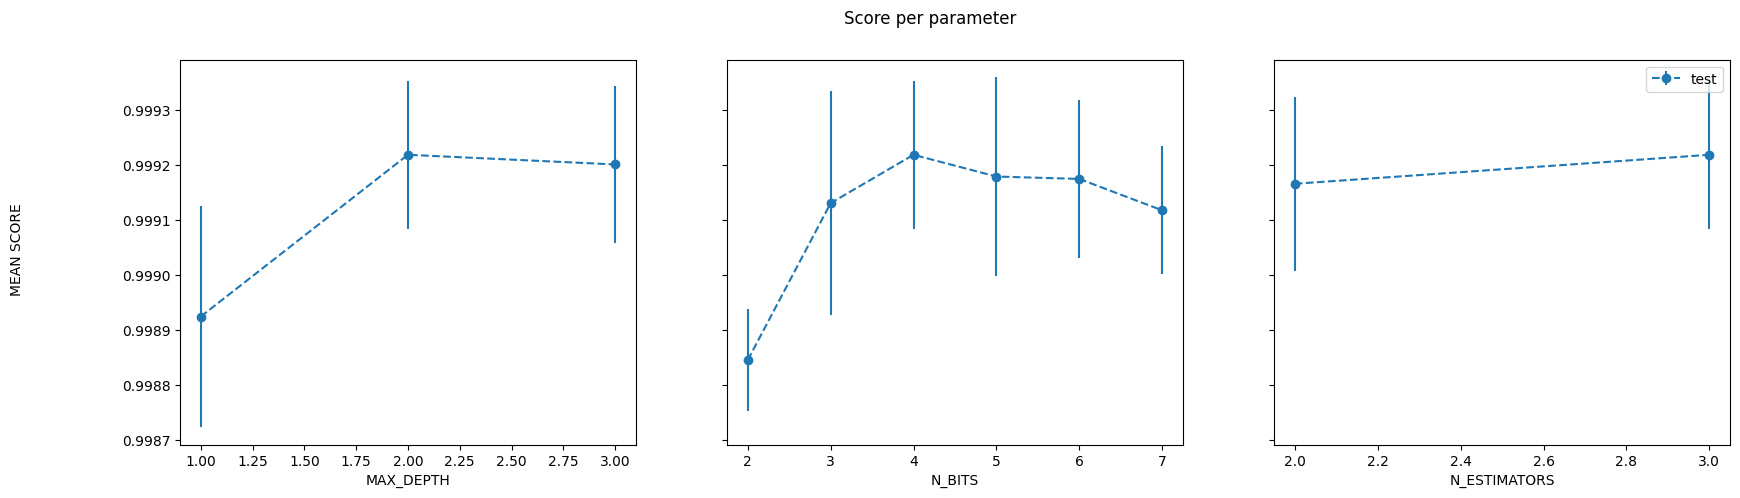

In [ ]:
def plot_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    #means_train = results['mean_fit_time']
    #stds_train = results['std_fit_time']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        #y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        #ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(gr_xgb)

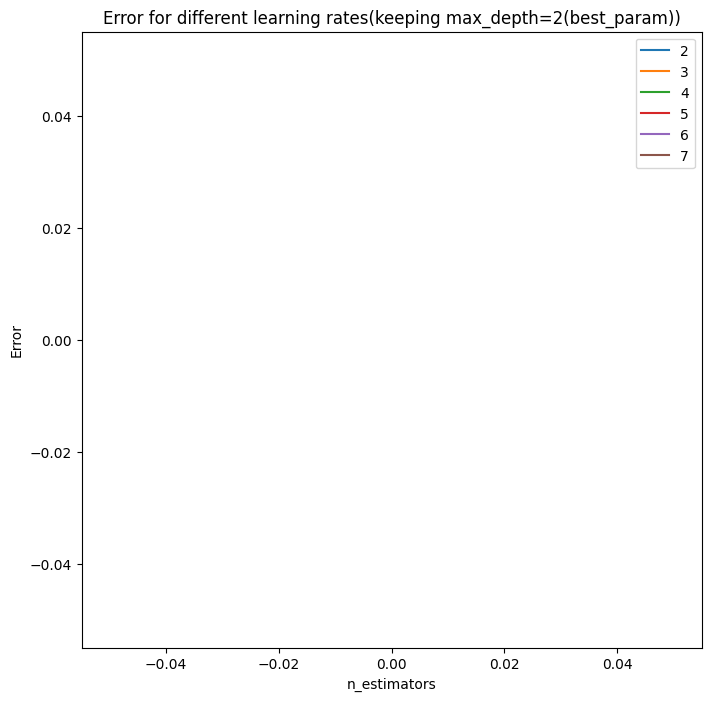

In [ ]:
y=[]
cvres = gr_xgb.cv_results_
best_md=gr_xgb.best_params_['max_depth']
la=grid_xgb_param['n_bits']
n_estimators=grid_xgb_param['n_estimators']

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if params["max_depth"]==best_md:
        y.append(np.sqrt(-mean_score))


y=np.array(y).reshape(len(la),len(n_estimators))


plt.figure(figsize=(8,8))
for y_arr, label in zip(y, la):
    plt.plot(n_estimators, y_arr, label=label)

plt.title('Error for different learning rates(keeping max_depth=%d(best_param))'%best_md)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.show()

In [ ]:
grid_logit_param = {
    "C": [ 1.0],
    #"n_bits": [7, 10, 13, 14],
    "n_bits": [7],
    #"solver": ["sag", "saga"],
    "solver": ["sag"],
    "multi_class": ["auto"],
}

gs_logit = grid_search(grid_logit_param, ConcreteLogisticRegression())


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'C': 1.0, 'multi_class': 'auto', 'n_bits': 7, 'solver': 'sag'}
Best score: 99.82%


In [ ]:
import time

import pandas as pd
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Import models from scikit-learn and XGBoost
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from xgboost import XGBClassifier as SklearnXGBoostClassifier

# Import models from Concrete ML
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBoostClassifier

CONCRETE_ML_MODELS = [
    ConcreteDecisionTreeClassifier,
    ConcreteLogisticRegression,
    ConcreteRandomForestClassifier,
    ConcreteXGBoostClassifier,
]

In [ ]:
def evaluate(
    model, x, y, test_size=0.33, show_circuit=False, predict_in_fhe=True, fhe_samples=None
):
    """Evaluate the given model using several metrics.

    The model is evaluated using the following metrics: accuracy, F1 score, precision, recall.
    For Concrete ML models, the inference's execution time is provided when done in FHE.

    Args:
        model: The initialized model to consider.
        x: The input data to consider.
        y: The target data to consider.
        test_size: The proportion to use for the test data. Default to 0.33.
        show_circuit: If the FHE circuit should be printed for Concrete ML models. Default to False.
        predict_in_fhe: If the inference should be executed in FHE for Concrete ML models. Else, it
            will only be simulated.
        fhe_sample: The number of samples to consider for evaluating the inference of Concrete ML
            models if predict_in_fhe is set to True. If None, the complete test set is used. Default
            to None.
    """
    evaluation_result = {}

    is_concrete_ml = model.__class__ in CONCRETE_ML_MODELS

    name = model.__class__.__name__ + (" (Concrete ML)" if is_concrete_ml else " (sklearn)")

    evaluation_result["name"] = name

    print(f"Evaluating model {name}")

    # Split the data into test and train sets. Stratify is used to make sure that the test set
    # contains some representative class distribution for targets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, stratify=y, test_size=test_size, random_state=1
    )
    test_length = len(x_test)

    evaluation_result["Test samples"] = test_length

    evaluation_result["n_bits"] = model.n_bits if is_concrete_ml else None

    # Normalization pipeline
    model = Pipeline(
        [
            ("preprocessor", StandardScaler()),
            ("model", model),
        ]
    )

    # Train the model
    model.fit(x_train, y_train)

    # Run the prediction and store its execution time
    y_pred = model.predict(x_test)

    # Evaluate the model
    # For Concrete ML models, this will execute the (quantized) inference in the clear
    evaluation_result["Accuracy (clear)"] = accuracy_score(y_test, y_pred)
    evaluation_result["F1 (clear)"] = f1_score(y_test, y_pred, average="macro")
    evaluation_result["Precision (clear)"] = precision_score(y_test, y_pred, average="macro")
    evaluation_result["Recall (clear)"] = recall_score(y_test, y_pred, average="macro")

    # If the model is from Concrete ML
    if is_concrete_ml:

        print("Compile the model")

        # Compile the model using the training data
        circuit = model["model"].compile(x_train)  # pylint: disable=no-member

        # Print the FHE circuit if needed
        if show_circuit:
            print(circuit)

        # Retrieve the circuit's max bit-width
        evaluation_result["max bit-width"] = circuit.graph.maximum_integer_bit_width()

        print("Predict (simulated)")

        # Run the prediction in the clear using FHE simulation, store its execution time and
        # evaluate the accuracy score
        y_pred_simulate = model.predict(x_test, fhe="simulate")

        evaluation_result["Accuracy (simulated)"] = accuracy_score(y_test, y_pred_simulate)

        # Run the prediction in FHE, store its execution time and evaluate the accuracy score
        if predict_in_fhe:
            if fhe_samples is not None:
                x_test = x_test[0:fhe_samples]
                y_test = y_test[0:fhe_samples]
                test_length = fhe_samples

            evaluation_result["FHE samples"] = test_length

            print("Predict (FHE)")

            before_time = time.time()
            y_pred_fhe = model.predict(x_test, fhe="execute")
            evaluation_result["FHE execution time (second per sample)"] = (
                time.time() - before_time
            ) / test_length

            evaluation_result["Accuracy (FHE)"] = accuracy_score(y_test, y_pred_fhe)

    print("Done !\n")

    return evaluation_result

In [ ]:
results = []

# Define the test size proportion
test_size = 0.2

# For testing FHE execution locally, define the number of inference to run. If None, the complete
# test set is used
fhe_samples = None

# Logistic regression
results.append(evaluate(SklearnLogisticRegression(), x_basic, y, test_size=test_size))
#results.append(evaluate(ConcreteLogisticRegression(), x_basic, y, test_size=test_size))

# Define the initialization parameters for tree-based models
init_params_dt = {"max_depth": 10}
init_params_rf = {"max_depth": 7, "n_estimators": 5}
init_params_xgb = {"max_depth": 7, "n_estimators": 5}
init_params_cml = {"n_bits": 3}

# Determine the type of models to evaluate
use_dt = True
use_rf = True
use_xgb = True
predict_in_fhe = True

# Decision tree models
if use_dt:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnDecisionTreeClassifier(**init_params_dt),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteDecisionTreeClassifier(**init_params_dt, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

# Random Forest
if use_rf:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnRandomForestClassifier(**init_params_rf),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteRandomForestClassifier(**init_params_rf, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

# XGBoost
if use_xgb:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnXGBoostClassifier(**init_params_xgb),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteXGBoostClassifier(**init_params_xgb, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

Evaluating model LogisticRegression (sklearn)
Done !

Evaluating model DecisionTreeClassifier (sklearn)
Done !

Evaluating model DecisionTreeClassifier (Concrete ML)
Compile the model
Predict (simulated)
Predict (FHE)


In [ ]:

pd.set_option("display.precision", 3)

results_dataframe = pd.DataFrame(results)
results_dataframe.fillna("")